# Proyecto: Métodos de ML para pronóstico de series de tiempo

## Contribución de los integrantes del equipo:

### Código
- Procesar y Cargar datos
  - Oscar Pérez
- GRU
  - Oscar Pérez
- LTSMs
  - Francisco Hernandéz
- MLP
  - Francisco Hernandéz
- ESN (adaptación de la clase empleada)
  - Francisco Hernandéz
- Ensamble
  - Francisco Hernandéz
- SVR
  - Oscar Pérez
- ARIMA
  - Francisco Hernandéz

* Integración y adaptación del código
  - Francisco Hernandéz
  - Oscar Pérez

### Reporte escrito
- Introducción:
  - Oscar Pérez
- Características relativas a la temporalidad de las series de tiempo
  - Oscar Pérez
- Modelos para pronósticos tradicionales
  - Oscar Pérez
- Tratamiento de los datos
  - Oscar Pérez
- Métricas de evaluación
  - Francisco Hernandéz
  - Oscar Pérez
- Datos de prueba
  - Francisco Hernandéz
- Modelos Autoregresivos de Medias Móviles Integrados
  - Francisco Hernandéz
- Support Vector Regression (SVR)
  - Oscar Pérez
- Perceptrón Multicapa (MLP)
  - Francisco Hernandéz
- Redes neuronales de memoria a corto y largo plazo (LTSM)
  - Francisco Hernandéz
- Echo State Network (ESN)
  - Francisco Hernandéz
- Gated Recurrent Units Network (GRU)
  - Oscar Pérez
- Métodos de ensamble
  - Francisco Hernandéz
- Conclusiones
  - Francisco Hernandéz
  - Oscar Pérez

- Integración:
  - Oscar Pérez
  
### Presentación
Análogo al reporte.
- Integración:
  - Francisco Hernandéz

## Procesar y Cargar datos

In [1]:
import pandas as pd
import datetime as dt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset

def process_data(data, var_tar, scaler, T, data_complete):
    """
    Procesa los datos para la creación de variables retrasadas y escaladas.

    Args:
        data (pd.DataFrame): Conjunto de datos de entrada.
        var_tar (str): Nombre de la variable objetivo.
        scaler (object): Escalador (StandardScaler, MinMaxScaler, etc.).
        T (int): Número de retrasos a considerar.
        data_complete (pd.DataFrame): Conjunto de datos completo escalado por el scaler de entrenamiento.

    Returns:
        X (np.ndarray): Conjunto de características con retrasos.
        y (np.ndarray): Variable objetivo desplazada.
        data_shifted (pd.DataFrame): Conjunto de datos transformado y desplazado.
    """
    data_shifted = data.copy()
    data_shifted['value_original'] = data_complete[var_tar]

    for t in range(1, T + 1):
        data_shifted[f"value_t-{t}"] = data_complete[var_tar].shift(t)

    data_shifted['y_t+1'] = data_complete[var_tar].shift(-1)

    cols = ['value_original', 'y_t+1'] + [f"value_t-{t}" for t in range(T, 0, -1)]
    data_shifted = data_shifted[cols]

    data_shifted = data_shifted.dropna(how='any')

    y = np.array(data_shifted['y_t+1'])
    X_cols = [f"value_t-{t}" for t in range(T, 0, -1)]
    X = np.array(data_shifted[X_cols])
    X = X.reshape(X.shape[0], T, 1)

    return X, y, data_shifted

def plot_data(data, var_tar, valid_st_data_load, test_st_data_load):
    """
    Grafica los datos diferenciando entre conjuntos de entrenamiento, validación y prueba.

    Args:
        data (pd.DataFrame): Conjunto de datos de entrada.
        var_tar (str): Nombre de la variable objetivo.
        valid_st_data_load (datetime): Fecha de inicio del conjunto de validación.
        test_st_data_load (datetime): Fecha de inicio del conjunto de prueba.
    """
    data = data.copy()
    data[data.index <= valid_st_data_load][[var_tar]].rename(columns={var_tar:'train'}) \
        .join(data[(data.index >= valid_st_data_load) & (data.index <= test_st_data_load)][[var_tar]] \
        .rename(columns={var_tar:'validation'}), how='outer') \
        .join(data[test_st_data_load:][[var_tar]].rename(columns={var_tar:'test'}), how='outer') \
        .plot(y=['train', 'validation', 'test'], figsize=(15, 8), fontsize=12)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel(var_tar, fontsize=12)
    plt.show()

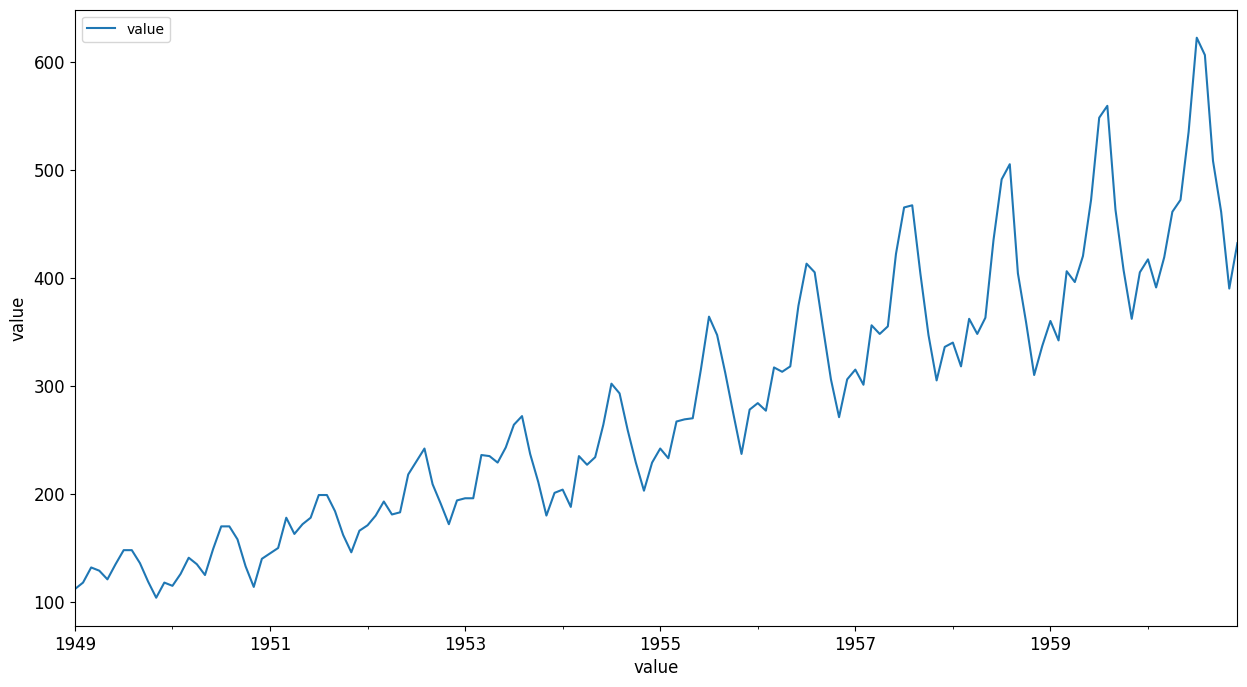

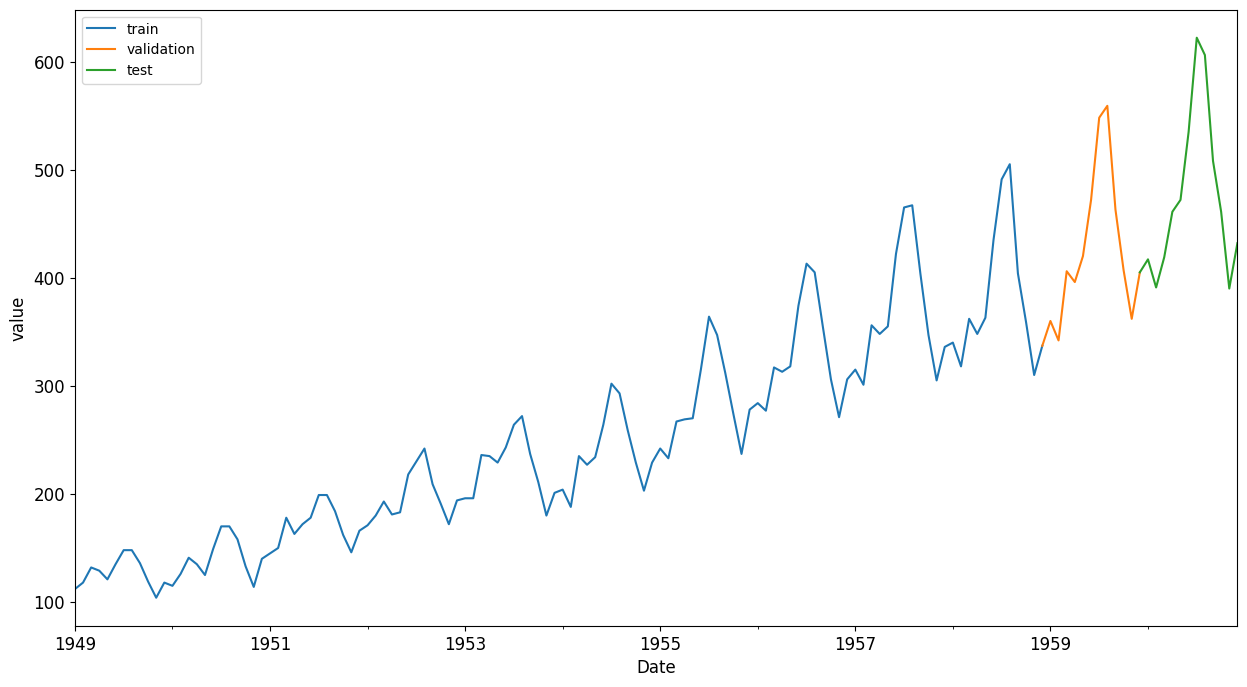

In [2]:
# Procesamos datos de AirPassengers
datos = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/AirPassengers.csv')[['date', 'value']]
#datos = pd.read_csv('https://raw.githubusercontent.com/OscUrPS/CIMAT/main/CD/RAW_DATA/NVDA.csv')[['Date', 'Close']]
var_date = 'date'
var_tar = 'value'

datos.index = pd.to_datetime(datos[var_date])
datos.drop([var_date], axis=1, inplace=True)
datos.plot(y=var_tar, subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel(var_tar, fontsize=12)
plt.ylabel(var_tar, fontsize=12)
plt.show()

test_st_data_load = max(datos.index) - DateOffset(months=12)
valid_st_data_load = test_st_data_load - DateOffset(months=12)
plot_data(datos, var_tar, valid_st_data_load, test_st_data_load)

T = 12 # Ventana de 12 meses
scaler = MinMaxScaler()

# Escalar todos los datos usando solo los datos de entrenamiento
train_data = datos[datos.index <= valid_st_data_load]
scaler.fit(train_data[[var_tar]])
datos_scaled = datos.copy()
datos_scaled[var_tar] = scaler.transform(datos[[var_tar]]).ravel()

train_data_scaled = train_data.copy()
train_data_scaled[var_tar] = scaler.transform(train_data[[var_tar]]).ravel()

X_train, y_train, _ = process_data(train_data_scaled, var_tar, scaler, T, datos_scaled)
valid_data = datos[(datos.index > valid_st_data_load) & (datos.index <= test_st_data_load)]
X_valid, y_valid, _ = process_data(valid_data, var_tar, scaler, T, datos_scaled)
test_data = datos[datos.index > test_st_data_load]
X_test, y_test, test_shifted = process_data(test_data, var_tar, scaler, T, datos_scaled)


## GRU

Epoch 1/200
2/2 [==============================] - 5s 2s/step - loss: 0.2058 - val_loss: 0.4932 - lr: 0.0075
Epoch 2/200
2/2 [==============================] - 0s 139ms/step - loss: 0.1480 - val_loss: 0.1599 - lr: 0.0075
Epoch 3/200
2/2 [==============================] - 0s 110ms/step - loss: 0.0206 - val_loss: 0.1091 - lr: 0.0075
Epoch 4/200
2/2 [==============================] - 0s 143ms/step - loss: 0.0175 - val_loss: 0.1217 - lr: 0.0075
Epoch 5/200
2/2 [==============================] - 0s 109ms/step - loss: 0.0168 - val_loss: 0.1460 - lr: 0.0075
Epoch 6/200
2/2 [==============================] - 0s 112ms/step - loss: 0.0185 - val_loss: 0.1137 - lr: 0.0075
Epoch 7/200
2/2 [==============================] - 0s 79ms/step - loss: 0.0166 - val_loss: 0.0911 - lr: 0.0075
Epoch 8/200
2/2 [==============================] - 0s 84ms/step - loss: 0.0193 - val_loss: 0.1509 - lr: 0.0074
Epoch 9/200
2/2 [==============================] - 0s 70ms/step - loss: 0.0200 - val_loss: 0.1193 - lr: 0.007

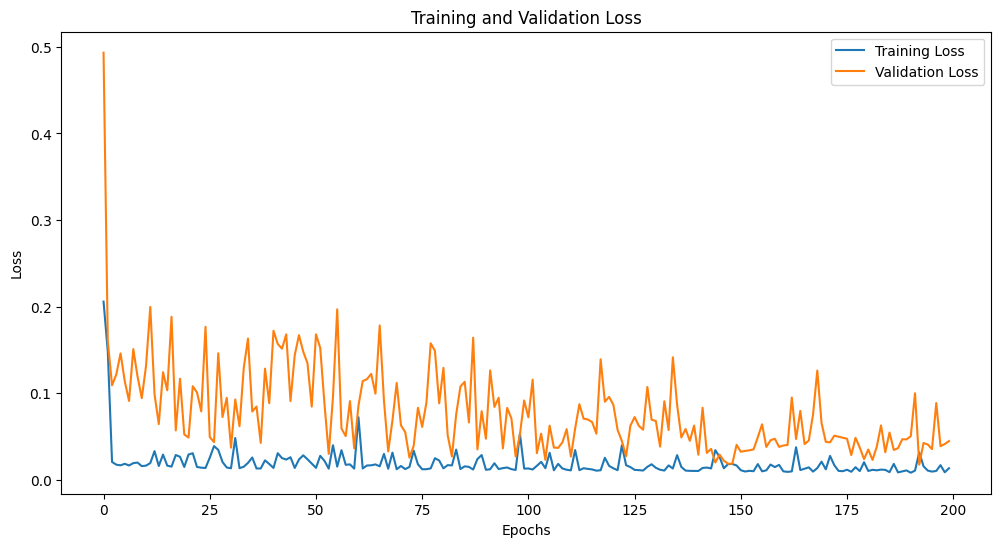

1/1 [==============================] - 0s 431ms/step
MAPE: 0.3246061594742693


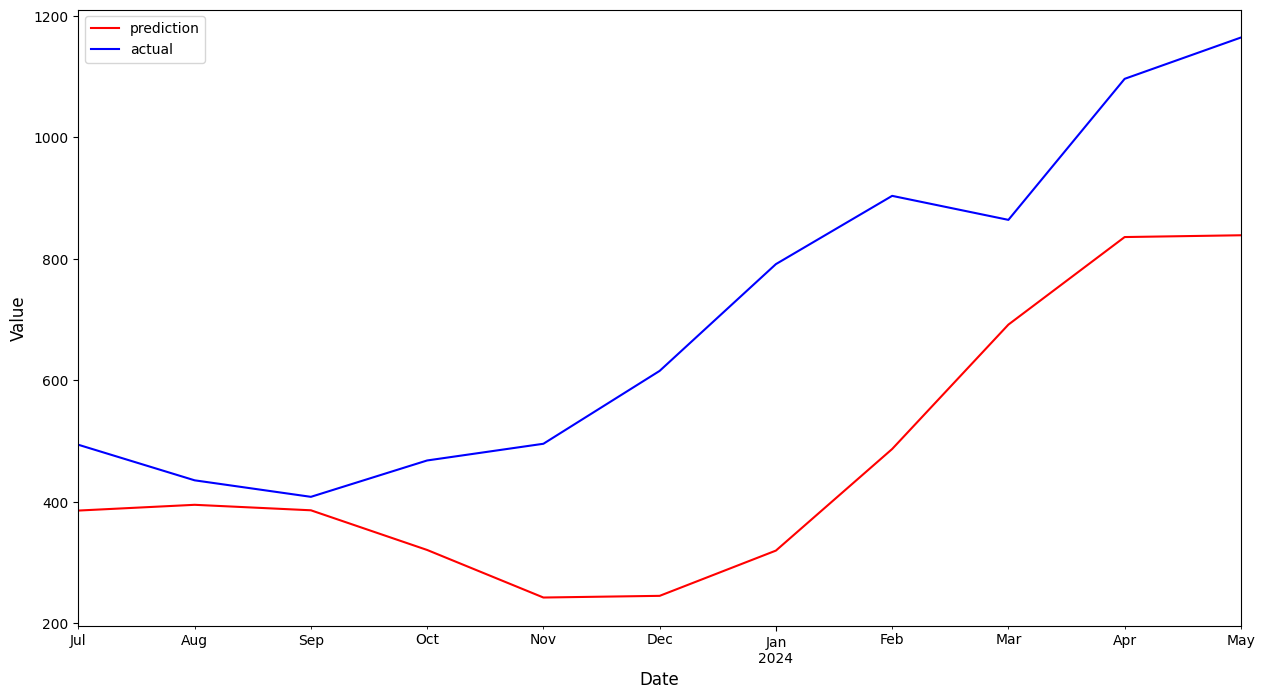

In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt

class GRUModel:
    """
    Clase para construir y entrenar un modelo GRU para series temporales.

    Args:
        latent_dim (int): Dimensión latente de las capas GRU.
        batch_size (int): Tamaño del lote.
        epochs (int): Número de épocas.
        horizon (int): Horizonte de predicción.
        T (int): Número de retrasos.
        lr (float): Tasa de aprendizaje.
        decay (float): Tasa de decaimiento del aprendizaje.
    """
    def __init__(self, latent_dim=120, batch_size=32, epochs=120, horizon=1, T=12, lr=0.001, decay=0.0):
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        self.epochs = epochs
        self.horizon = horizon
        self.T = T
        self.lr = lr
        self.decay = decay
        self.model = self.build_model()

    def build_model(self):
        """
        Construye el modelo GRU.

        Returns:
            model (Sequential): El modelo compilado.
        """
        model = Sequential()
        model.add(GRU(self.latent_dim, input_shape=(self.T, 1)))
        model.add(Dense(self.horizon))
        optimizer = RMSprop(learning_rate=self.lr)
        model.compile(optimizer=optimizer, loss='mse')
        return model

    def lr_schedule(self, epoch):
        """
        Planificación de la tasa de aprendizaje.

        Args:
            epoch (int): Número de época.

        Returns:
            float: Tasa de aprendizaje ajustada.
        """
        return self.lr * (1. / (1. + self.decay * epoch))

    def train(self, X_train, y_train, X_valid, y_valid, plot_loss=False):
        """
        Entrena el modelo GRU.

        Args:
            X_train (np.ndarray): Características de entrenamiento.
            y_train (np.ndarray): Objetivos de entrenamiento.
            X_valid (np.ndarray): Características de validación.
            y_valid (np.ndarray): Objetivos de validación.
            plot_loss (bool): Si se debe graficar la pérdida.

        Returns:
            history (History): Historial de entrenamiento.
        """
        early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100)
        lr_scheduler = LearningRateScheduler(self.lr_schedule)
        self.history = self.model.fit(X_train, y_train,
                                      batch_size=self.batch_size,
                                      epochs=self.epochs,
                                      validation_data=(X_valid, y_valid),
                                      callbacks=[early_stop, lr_scheduler],
                                      verbose=1)
        if plot_loss:
            self.plot_loss(self.history)
        return self.history

    def predict(self, X_test):
        """
        Realiza predicciones usando el modelo entrenado.

        Args:
            X_test (np.ndarray): Conjunto de características de prueba.

        Returns:
            np.ndarray: Predicciones del modelo.
        """
        return self.model.predict(X_test)

    def evaluate(self, predictions, y_test, dates, scaler):
        """
        Evalúa las predicciones del modelo.

        Args:
            predictions (np.ndarray): Predicciones del modelo.
            y_test (np.ndarray): Valores reales de prueba.
            dates (pd.DatetimeIndex): Fechas correspondientes.
            scaler (object): Escalador usado para la normalización.

        Returns:
            pd.DataFrame: DataFrame con las predicciones y valores reales.
        """
        df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, self.horizon+1)])
        df['date'] = dates
        df = pd.melt(df, id_vars='date', value_name='prediction', var_name='h')
        df['actual'] = np.transpose(y_test).ravel()
        df[['prediction', 'actual']] = scaler.inverse_transform(df[['prediction', 'actual']])
        return df

    def plot_predictions(self, df):
        """
        Grafica las predicciones del modelo contra los valores reales.

        Args:
            df (pd.DataFrame): DataFrame con las predicciones y valores reales.
        """
        df.plot(x='date', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8))
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Value', fontsize=12)
        plt.show()

    def calculate_mape(self, predictions, actuals):
        """
        Calcula el MAPE (Mean Absolute Percentage Error).

        Args:
            predictions (np.ndarray): Predicciones del modelo.
            actuals (np.ndarray): Valores reales.

        Returns:
            float: MAPE calculado.
        """
        return np.mean(np.abs((predictions - actuals) / actuals))

    def plot_loss(self, history):
        """
        Grafica la pérdida de entrenamiento y validación.

        Args:
            history (History): Historial de entrenamiento del modelo.
        """
        plt.figure(figsize=(12, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()


# Param
LATENT_DIM = 120
BATCH_SIZE = 32
EPOCHS = 200
HORIZON = 1
T = 12
LR = 0.0075
DECAY = .001

gru_model = GRUModel(latent_dim=LATENT_DIM, batch_size=BATCH_SIZE, epochs=EPOCHS, horizon=HORIZON, T=T, lr=LR, decay=DECAY)
history = gru_model.train(X_train, y_train, X_valid, y_valid, plot_loss=True)
predictions = gru_model.predict(X_test)
evaluation_df = gru_model.evaluate(predictions, y_test, test_shifted.index, scaler)

print("MAPE:", gru_model.calculate_mape(evaluation_df['prediction'], evaluation_df['actual']))

gru_model.plot_predictions(evaluation_df)

del gru_model
del history

## LTSMs

c:\Python3.12\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.1915 - val_loss: 0.3978 - learning_rate: 1.0000e-04
Epoch 2/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0908 - val_loss: 0.1722 - learning_rate: 9.9900e-05
Epoch 3/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0378 - val_loss: 0.0392 - learning_rate: 9.9800e-05
Epoch 4/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0102 - val_loss: 0.0575 - learning_rate: 9.9701e-05
Epoch 5/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0260 - val_loss: 0.0447 - learning_rate: 9.9602e-05
Epoch 6/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0155 - val_loss: 0.0369 - learning_rate: 9.9502e-05
Epoch 7/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0125 - val_loss: 0.0513 - learning_rate: 9.9404e-05
Epoch 8/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0157 - val_loss: 0.0538 - learning_rate: 9.9305e-05
Epoch 9/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0157 - val_loss: 0.0435 - learning_rate: 9.9

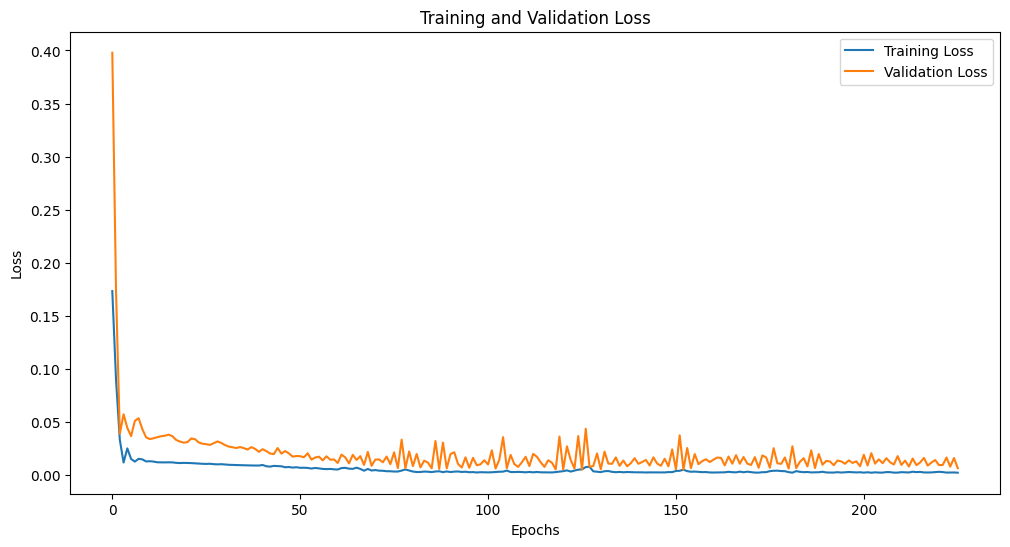

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
MAPE: 0.05866590842351458


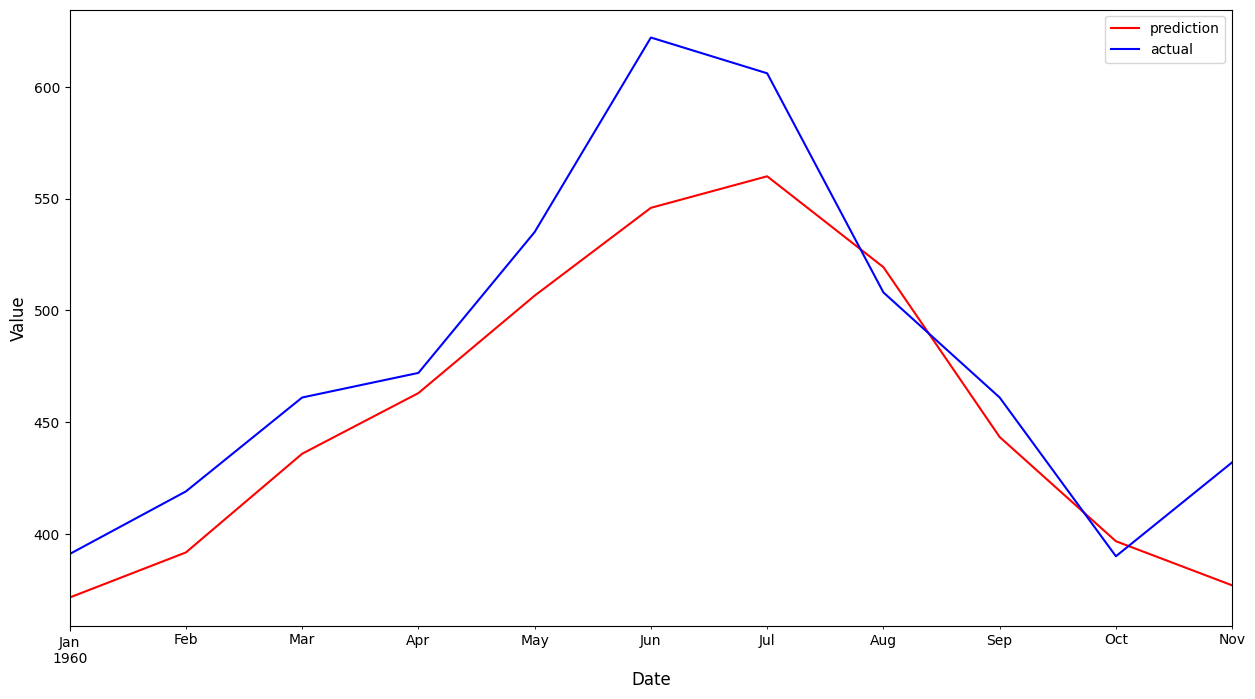

In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.optimizers import Adam
import matplotlib.pyplot as plt

class LSTMModel:
    """
    Clase para construir y entrenar un modelo LSTM para series temporales.

    Args:
        latent_dim (int): Dimensión latente de las capas LSTM.
        batch_size (int): Tamaño del lote.
        epochs (int): Número de épocas.
        horizon (int): Horizonte de predicción.
        T (int): Número de retrasos.
        lr (float): Tasa de aprendizaje.
        decay (float): Tasa de decaimiento del aprendizaje.
    """
    def __init__(self, latent_dim=500, batch_size=16, epochs=100, horizon=1, T=12, lr=0.001, decay=0.0):
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        self.epochs = epochs
        self.horizon = horizon
        self.T = T
        self.lr = lr
        self.decay = decay
        self.model = self.build_model()

    def build_model(self):
        """
        Construye el modelo LSTM.

        Returns:
            model (Sequential): El modelo compilado.
        """
        model = Sequential()
        model.add(LSTM(self.latent_dim, input_shape=(self.T, 1)))
        model.add(Dense(self.horizon))
        optimizer = Adam(learning_rate=self.lr)
        model.compile(optimizer=optimizer, loss='mse')
        return model

    def lr_schedule(self, epoch):
        """
        Planificación de la tasa de aprendizaje.

        Args:
            epoch (int): Número de época.

        Returns:
            float: Tasa de aprendizaje ajustada.
        """
        return self.lr * (1. / (1. + self.decay * epoch))

    def train(self, X_train, y_train, X_valid, y_valid, plot_loss=False):
        """
        Entrena el modelo LSTM.

        Args:
            X_train (np.ndarray): Características de entrenamiento.
            y_train (np.ndarray): Objetivos de entrenamiento.
            X_valid (np.ndarray): Características de validación.
            y_valid (np.ndarray): Objetivos de validación.
            plot_loss (bool): Si se debe graficar la pérdida.

        Returns:
            history (History): Historial de entrenamiento.
        """
        early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100)
        lr_scheduler = LearningRateScheduler(self.lr_schedule)
        self.history = self.model.fit(X_train, y_train,
                                      batch_size=self.batch_size,
                                      epochs=self.epochs,
                                      validation_data=(X_valid, y_valid),
                                      callbacks=[early_stop, lr_scheduler],
                                      verbose=1)
        if plot_loss:
            self.plot_loss(self.history)
        return self.history

    def predict(self, X_test):
        """
        Realiza predicciones usando el modelo entrenado.

        Args:
            X_test (np.ndarray): Conjunto de características de prueba.

        Returns:
            np.ndarray: Predicciones del modelo.
        """
        return self.model.predict(X_test)

    def evaluate(self, predictions, y_test, dates, scaler):
        """
        Evalúa las predicciones del modelo.

        Args:
            predictions (np.ndarray): Predicciones del modelo.
            y_test (np.ndarray): Valores reales de prueba.
            dates (pd.DatetimeIndex): Fechas correspondientes.
            scaler (object): Escalador usado para la normalización.

        Returns:
            pd.DataFrame: DataFrame con las predicciones y valores reales.
        """
        df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, self.horizon+1)])
        df['date'] = dates
        df = pd.melt(df, id_vars='date', value_name='prediction', var_name='h')
        df['actual'] = np.transpose(y_test).ravel()
        df[['prediction', 'actual']] = scaler.inverse_transform(df[['prediction', 'actual']])
        return df

    def plot_predictions(self, df):
        """
        Grafica las predicciones del modelo contra los valores reales.

        Args:
            df (pd.DataFrame): DataFrame con las predicciones y valores reales.
        """
        df.plot(x='date', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8))
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Value', fontsize=12)
        plt.show()

    def calculate_mape(self, predictions, actuals):
        """
        Calcula el MAPE (Mean Absolute Percentage Error).

        Args:
            predictions (np.ndarray): Predicciones del modelo.
            actuals (np.ndarray): Valores reales.

        Returns:
            float: MAPE calculado.
        """
        return np.mean(np.abs((predictions - actuals) / actuals))

    def plot_loss(self, history):
        """
        Grafica la pérdida de entrenamiento y validación.

        Args:
            history (History): Historial de entrenamiento del modelo.
        """
        plt.figure(figsize=(12, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()


LATENT_DIM = 1000
BATCH_SIZE = 32
EPOCHS = 250
HORIZON = 1
T = 12
LR = 0.0001
DECAY = .001

lstm_model = LSTMModel(latent_dim=LATENT_DIM, batch_size=BATCH_SIZE, epochs=EPOCHS, horizon=HORIZON, T=T, lr=LR, decay=DECAY)
history = lstm_model.train(X_train, y_train, X_valid, y_valid, plot_loss=True)
predictions = lstm_model.predict(X_test)
evaluation_df = lstm_model.evaluate(predictions, y_test, test_shifted.index, scaler)

print("MAPE:", lstm_model.calculate_mape(evaluation_df['prediction'], evaluation_df['actual']))

lstm_model.plot_predictions(evaluation_df)


In [ ]:
del lstm_model
del history

## MLP

Epoch 1/500


c:\Python3.12\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1214 - val_loss: 0.0327
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0144 - val_loss: 0.0524
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0133 - val_loss: 0.0168
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0077 - val_loss: 0.0059
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0042 - val_loss: 0.0198
Epoch 6/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0051 - val_loss: 0.0040
Epoch 7/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 8/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - val_loss: 0.0083
Epoch 9/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0021 - val_loss: 0.0028
Epoch 10/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - val_loss: 0.0061
Epoch 11/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 12/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 

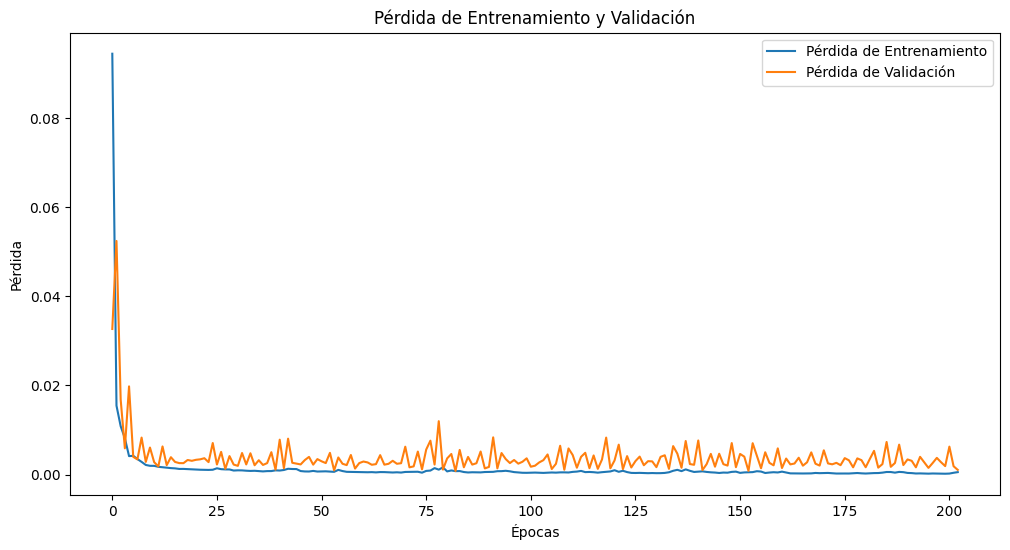

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
MAPE: 0.023548551821250454


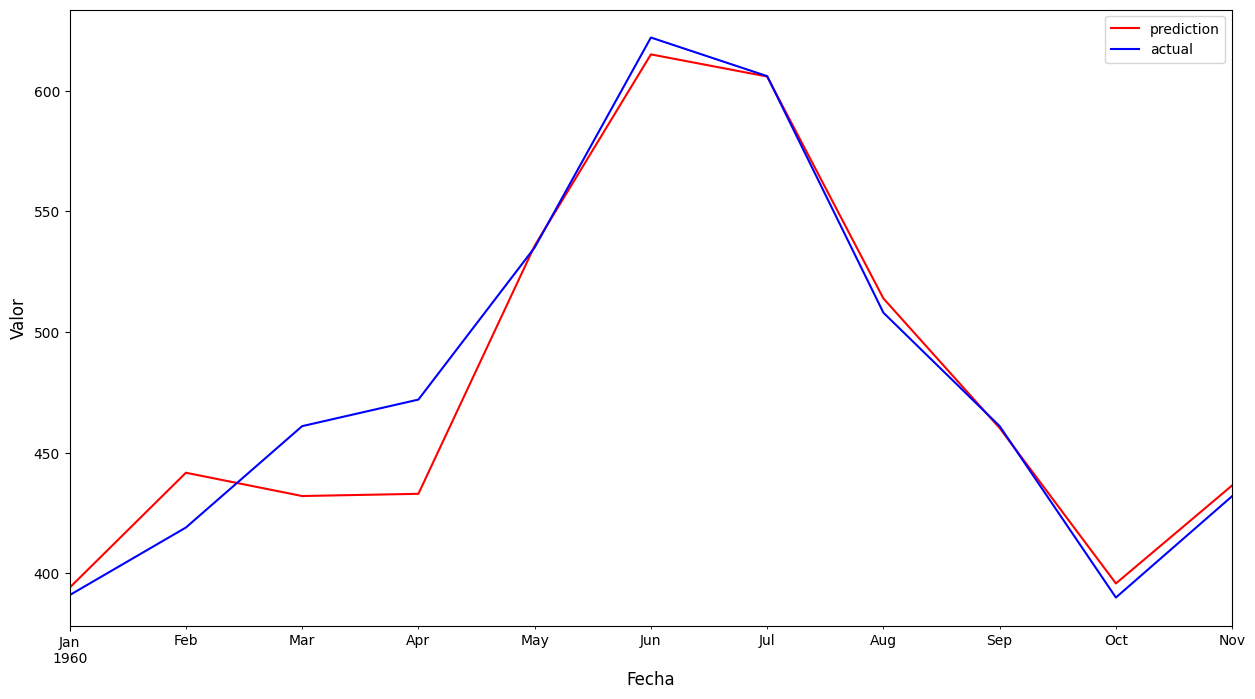

In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

class MLPModel:
   def __init__(self, input_shape, layers, neurons, batch_size=32, epochs=20, horizon=1, lr=0.001, decay=0.0, activation='relu'):
       """
       Inicializa una instancia de MLPModel.

       Args:
           input_shape (tupla): La forma de los datos de entrada.
           layers (int): El número de capas ocultas en la red neuronal.
           neurons (int): El número de neuronas en cada capa oculta.
           batch_size (int, opcional): El tamaño de lote para el entrenamiento. Por defecto es 32.
           epochs (int, opcional): El número de épocas para el entrenamiento. Por defecto es 20.
           horizon (int, opcional): El número de pasos futuros a predecir. Por defecto es 1.
           lr (float, opcional): La tasa de aprendizaje para el optimizador. Por defecto es 0.001.
           decay (float, opcional): La tasa de decaimiento para la tasa de aprendizaje. Por defecto es 0.0.
           activation (str, opcional): La función de activación para las capas ocultas. Por defecto es 'relu'.
       """
       self.input_shape = input_shape
       self.layers = layers
       self.neurons = neurons
       self.batch_size = batch_size
       self.epochs = epochs
       self.horizon = horizon
       self.lr = lr
       self.decay = decay
       self.activation = activation
       self.model = self.build_model()

   def build_model(self):
       """
       Construye el modelo de red neuronal.

       Returns:
           model (keras.models.Sequential): El modelo de red neuronal construido.
       """
       model = Sequential()
       model.add(Flatten(input_shape=self.input_shape))
       for _ in range(self.layers):
           model.add(Dense(self.neurons, activation=self.activation))
       model.add(Dense(self.horizon))
       model.compile(optimizer='adam', loss='mse')
       return model

   def train(self, X_train, y_train, X_valid, y_valid, plot_loss=False):
       """
       Entrena el modelo en los datos de entrenamiento y validación.

       Args:
           X_train (np.array): Los datos de entrada para el entrenamiento.
           y_train (np.array): Las etiquetas o valores objetivo para el entrenamiento.
           X_valid (np.array): Los datos de entrada para la validación.
           y_valid (np.array): Las etiquetas o valores objetivo para la validación.
           plot_loss (bool, opcional): Si es True, grafica la curva de pérdida de entrenamiento y validación.

       Returns:
           history (keras.callbacks.History): El historial de entrenamiento.
       """
       early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=120)
       self.history = self.model.fit(X_train, y_train,
                                     batch_size=self.batch_size,
                                     epochs=self.epochs,
                                     validation_data=(X_valid, y_valid),
                                     callbacks=[early_stop],
                                     verbose=1)
       if plot_loss:
           self.plot_loss(self.history)
       return self.history

   def predict(self, X_test):
       """
       Realiza predicciones en los datos de entrada.

       Args:
           X_test (np.array): Los datos de entrada para realizar predicciones.

       Returns:
           predictions (np.array): Las predicciones del modelo.
       """
       return self.model.predict(X_test)

   def evaluate(self, predictions, y_test, dates, scaler):
       """
       Evalúa las predicciones del modelo y crea un DataFrame con las predicciones y valores reales.

       Args:
           predictions (np.array): Las predicciones del modelo.
           y_test (np.array): Los valores reales o etiquetas.
           dates (np.array): Las fechas correspondientes a los datos.
           scaler (sklearn.preprocessing.MinMaxScaler): El objeto de escalado utilizado para preprocesar los datos.

       Returns:
           df (pd.DataFrame): Un DataFrame con las predicciones, fechas y valores reales.
       """
       df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, self.horizon+1)])
       df['date'] = dates
       df = pd.melt(df, id_vars='date', value_name='prediction', var_name='h')
       df['actual'] = np.transpose(y_test).ravel()
       df[['prediction', 'actual']] = scaler.inverse_transform(df[['prediction', 'actual']])
       return df

   def plot_predictions(self, df):
       """
       Grafica las predicciones y los valores reales.

       Args:
           df (pd.DataFrame): El DataFrame con las predicciones y valores reales.
       """
       df.plot(x='date', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8))
       plt.xlabel('Fecha', fontsize=12)
       plt.ylabel('Valor', fontsize=12)
       plt.show()

   def calculate_mape(self, predictions, actuals):
       """
       Calcula el Error Porcentual Absoluto Medio (MAPE) entre las predicciones y los valores reales.

       Args:
           predictions (np.array): Las predicciones del modelo.
           actuals (np.array): Los valores reales.

       Returns:
           mape (float): El MAPE calculado.
       """
       return np.mean(np.abs((predictions - actuals) / actuals))

   def plot_loss(self, history):
       """
       Grafica la curva de pérdida de entrenamiento y validación.

       Args:
           history (keras.callbacks.History): El historial de entrenamiento.
       """
       plt.figure(figsize=(12, 6))
       plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
       plt.plot(history.history['val_loss'], label='Pérdida de Validación')
       plt.title('Pérdida de Entrenamiento y Validación')
       plt.xlabel('Épocas')
       plt.ylabel('Pérdida')
       plt.legend()
       plt.show()

INPUT_SHAPE = (T, 1)
LAYERS = 2
NEURONS = 1000
BATCH_SIZE = 32
EPOCHS = 500
HORIZON = 1
LR = 0.001
DECAY = 0.6
activation='relu'

mlp_model = MLPModel(input_shape=INPUT_SHAPE, layers=LAYERS, neurons=NEURONS,
                     batch_size=BATCH_SIZE, epochs=EPOCHS, horizon=HORIZON, lr=LR,
                     decay=DECAY, activation= activation)

history = mlp_model.train(X_train, y_train, X_valid, y_valid, plot_loss=True)
predictions = mlp_model.predict(X_test)
evaluation_df = mlp_model.evaluate(predictions, y_test, test_shifted.index, scaler)

print("MAPE:", mlp_model.calculate_mape(evaluation_df['prediction'], evaluation_df['actual']))

mlp_model.plot_predictions(evaluation_df)


In [ ]:
del mlp_model
del history

## ESN

In [ ]:
import numpy as np
# * pyESN: Echo State Networks in Python. https://github.com/cknd/pyESN

def correct_dimensions(s, targetlength):
    """checks the dimensionality of some numeric argument s, broadcasts it
       to the specified length if possible.

    Args:
        s: None, scalar or 1D array
        targetlength: expected length of s

    Returns:
        None if s is None, else numpy vector of length targetlength
    """
    if s is not None:
        s = np.array(s)
        if s.ndim == 0:
            s = np.array([s] * targetlength)
        elif s.ndim == 1:
            if not len(s) == targetlength:
                raise ValueError("arg must have length " + str(targetlength))
        else:
            raise ValueError("Invalid argument")
    return s


def identity(x):
    return x


class ESN():

    def __init__(self, n_inputs, n_outputs, n_reservoir=200,
                 spectral_radius=0.95, sparsity=0, noise=0.001, input_shift=None,
                 input_scaling=None, teacher_forcing=True, feedback_scaling=None,
                 teacher_scaling=None, teacher_shift=None,
                 out_activation=identity, inverse_out_activation=identity,
                 random_state=None, silent=True):
        """
        Args:
            n_inputs: nr of input dimensions
            n_outputs: nr of output dimensions
            n_reservoir: nr of reservoir neurons
            spectral_radius: spectral radius of the recurrent weight matrix
            sparsity: proportion of recurrent weights set to zero
            noise: noise added to each neuron (regularization)
            input_shift: scalar or vector of length n_inputs to add to each
                        input dimension before feeding it to the network.
            input_scaling: scalar or vector of length n_inputs to multiply
                        with each input dimension before feeding it to the netw.
            teacher_forcing: if True, feed the target back into output units
            teacher_scaling: factor applied to the target signal
            teacher_shift: additive term applied to the target signal
            out_activation: output activation function (applied to the readout)
            inverse_out_activation: inverse of the output activation function
            random_state: positive integer seed, np.rand.RandomState object,
                          or None to use numpy's builting RandomState.
            silent: supress messages
        """
        # check for proper dimensionality of all arguments and write them down.
        self.n_inputs = n_inputs
        self.n_reservoir = n_reservoir
        self.n_outputs = n_outputs
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.noise = noise
        self.input_shift = correct_dimensions(input_shift, n_inputs)
        self.input_scaling = correct_dimensions(input_scaling, n_inputs)

        self.teacher_scaling = teacher_scaling
        self.teacher_shift = teacher_shift

        self.out_activation = out_activation
        self.inverse_out_activation = inverse_out_activation
        self.random_state = random_state

        # the given random_state might be either an actual RandomState object,
        # a seed or None (in which case we use numpy's builtin RandomState)
        if isinstance(random_state, np.random.RandomState):
            self.random_state_ = random_state
        elif random_state:
            try:
                self.random_state_ = np.random.RandomState(random_state)
            except TypeError as e:
                raise Exception("Invalid seed: " + str(e))
        else:
            self.random_state_ = np.random.mtrand._rand

        self.teacher_forcing = teacher_forcing
        self.silent = silent
        self.initweights()

    def initweights(self):
        # initialize recurrent weights:
        # begin with a random matrix centered around zero:
        W = self.random_state_.rand(self.n_reservoir, self.n_reservoir) - 0.5
        # delete the fraction of connections given by (self.sparsity):
        W[self.random_state_.rand(*W.shape) < self.sparsity] = 0
        # compute the spectral radius of these weights:
        radius = np.max(np.abs(np.linalg.eigvals(W)))
        # rescale them to reach the requested spectral radius:
        self.W = W * (self.spectral_radius / radius)

        # random input weights:
        self.W_in = self.random_state_.rand(
            self.n_reservoir, self.n_inputs) * 2 - 1
        # random feedback (teacher forcing) weights:
        self.W_feedb = self.random_state_.rand(
            self.n_reservoir, self.n_outputs) * 2 - 1

    def _update(self, state, input_pattern, output_pattern):
        """performs one update step.

        i.e., computes the next network state by applying the recurrent weights
        to the last state & and feeding in the current input and output patterns
        """
        if self.teacher_forcing:
            preactivation = (np.dot(self.W, state)
                             + np.dot(self.W_in, input_pattern)
                             + np.dot(self.W_feedb, output_pattern))
        else:
            preactivation = (np.dot(self.W, state)
                             + np.dot(self.W_in, input_pattern))
        return (np.tanh(preactivation)
                + self.noise * (self.random_state_.rand(self.n_reservoir) - 0.5))

    def _scale_inputs(self, inputs):
        """for each input dimension j: multiplies by the j'th entry in the
        input_scaling argument, then adds the j'th entry of the input_shift
        argument."""
        if self.input_scaling is not None:
            inputs = np.dot(inputs, np.diag(self.input_scaling))
        if self.input_shift is not None:
            inputs = inputs + self.input_shift
        return inputs

    def _scale_teacher(self, teacher):
        """multiplies the teacher/target signal by the teacher_scaling argument,
        then adds the teacher_shift argument to it."""
        if self.teacher_scaling is not None:
            teacher = teacher * self.teacher_scaling
        if self.teacher_shift is not None:
            teacher = teacher + self.teacher_shift
        return teacher

    def _unscale_teacher(self, teacher_scaled):
        """inverse operation of the _scale_teacher method."""
        if self.teacher_shift is not None:
            teacher_scaled = teacher_scaled - self.teacher_shift
        if self.teacher_scaling is not None:
            teacher_scaled = teacher_scaled / self.teacher_scaling
        return teacher_scaled

    def fit(self, inputs, outputs, inspect=False):
        """
        Collect the network's reaction to training data, train readout weights.

        Args:
            inputs: array of dimensions (N_training_samples x n_inputs)
            outputs: array of dimension (N_training_samples x n_outputs)
            inspect: show a visualisation of the collected reservoir states

        Returns:
            the network's output on the training data, using the trained weights
        """
        # transform any vectors of shape (x,) into vectors of shape (x,1):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        if outputs.ndim < 2:
            outputs = np.reshape(outputs, (len(outputs), -1))
        # transform input and teacher signal:
        inputs_scaled = self._scale_inputs(inputs)
        teachers_scaled = self._scale_teacher(outputs)

        if not self.silent:
            print("harvesting states...")
        # step the reservoir through the given input,output pairs:
        states = np.zeros((inputs.shape[0], self.n_reservoir))
        for n in range(1, inputs.shape[0]):
            states[n, :] = self._update(states[n - 1], inputs_scaled[n, :],
                                        teachers_scaled[n - 1, :])

        # learn the weights, i.e. find the linear combination of collected
        # network states that is closest to the target output
        if not self.silent:
            print("fitting...")
        # we'll disregard the first few states:
        transient = min(int(inputs.shape[1] / 10), 100)
        # include the raw inputs:
        extended_states = np.hstack((states, inputs_scaled))
        # Solve for W_out:
        self.W_out = np.dot(np.linalg.pinv(extended_states[transient:, :]),
                            self.inverse_out_activation(teachers_scaled[transient:, :])).T

        # remember the last state for later:
        self.laststate = states[-1, :]
        self.lastinput = inputs[-1, :]
        self.lastoutput = teachers_scaled[-1, :]

        # optionally visualize the collected states
        if inspect:
            from matplotlib import pyplot as plt
            # (^-- we depend on matplotlib only if this option is used)
            plt.figure(
                figsize=(states.shape[0] * 0.0025, states.shape[1] * 0.01))
            plt.imshow(extended_states.T, aspect='auto',
                       interpolation='nearest')
            plt.colorbar()

        if not self.silent:
            print("training error:")
        # apply learned weights to the collected states:
        pred_train = self._unscale_teacher(self.out_activation(
            np.dot(extended_states, self.W_out.T)))
        if not self.silent:
            print(np.sqrt(np.mean((pred_train - outputs)**2)))
        return pred_train

    def predict(self, inputs, continuation=True):
        """
        Apply the learned weights to the network's reactions to new input.

        Args:
            inputs: array of dimensions (N_test_samples x n_inputs)
            continuation: if True, start the network from the last training state

        Returns:
            Array of output activations
        """
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        n_samples = inputs.shape[0]

        if continuation:
            laststate = self.laststate
            lastinput = self.lastinput
            lastoutput = self.lastoutput
        else:
            laststate = np.zeros(self.n_reservoir)
            lastinput = np.zeros(self.n_inputs)
            lastoutput = np.zeros(self.n_outputs)

        inputs = np.vstack([lastinput, self._scale_inputs(inputs)])
        states = np.vstack(
            [laststate, np.zeros((n_samples, self.n_reservoir))])
        outputs = np.vstack(
            [lastoutput, np.zeros((n_samples, self.n_outputs))])

        for n in range(n_samples):
            states[
                n + 1, :] = self._update(states[n, :], inputs[n + 1, :], outputs[n, :])
            outputs[n + 1, :] = self.out_activation(np.dot(self.W_out,
                                                           np.concatenate([states[n + 1, :], inputs[n + 1, :]])))

        return self._unscale_teacher(self.out_activation(outputs[1:]))

MAPE: 0.14685272381639006


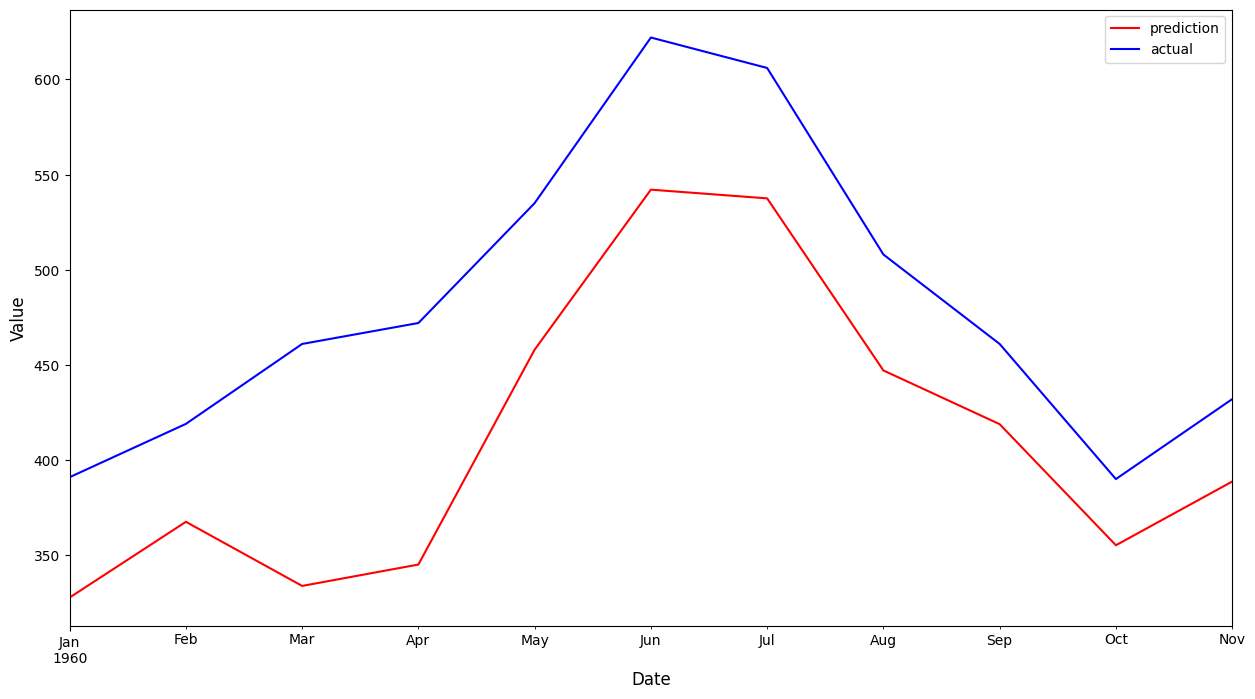

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

def mape(ts_predictions, actuals):
    """Mean absolute percentage error"""
    return ((np.abs(ts_predictions - actuals) / actuals).mean())

N_RESERVOIR = 850
SPECTRAL_RADIUS = 0.90
SPARSITY = 0.55
NOISE = 0.0001

esn = ESN(n_inputs=T,
          n_outputs=1,
          n_reservoir=N_RESERVOIR,
          spectral_radius=SPECTRAL_RADIUS,
          sparsity=SPARSITY,
          noise=NOISE)

esn.fit(X_train[:, :, 0], y_train)
esn_predictions = esn.predict(X_test[:, :, 0])

ev_ts_data = pd.DataFrame(esn_predictions, columns=['prediction'])
ev_ts_data[var_date] = test_shifted.index
ev_ts_data['actual'] = np.transpose(y_test).ravel()
ev_ts_data[['prediction', 'actual']] = scaler.inverse_transform(ev_ts_data[['prediction', 'actual']])
ev_ts_data.head()

print("MAPE:", mape(ev_ts_data['prediction'], ev_ts_data['actual']))

ev_ts_data.plot(x=var_date, y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.show()

## Ensamble

c:\Python3.12\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Python3.12\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Entrenando modelo GRU
Epoch 1/260
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.2502 - val_loss: 0.4555 - learning_rate: 0.0010
Epoch 2/260
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0743 - val_loss: 0.1844 - learning_rate: 9.9010e-04
Epoch 3/260
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0300 - val_loss: 0.0935 - learning_rate: 9.8039e-04
Epoch 4/260
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0284 - val_loss: 0.0949 - learning_rate: 9.7087e-04
Epoch 5/260
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0215 - val_loss: 0.0820 - learning_rate: 9.6154e-04
Epoch 6/260
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0252 - val_loss: 0.1021 - learning_rate: 9.5238e-04
Epoch 7/260
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0261 - val_loss: 0.0744 - learning_rate: 9.4340e-04
Epoch 8/260
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0202 - val_loss: 0.0594 - learning_rate: 9.3458e-04
Epoch 9/260
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0186 - val_loss: 0.0507 - learning

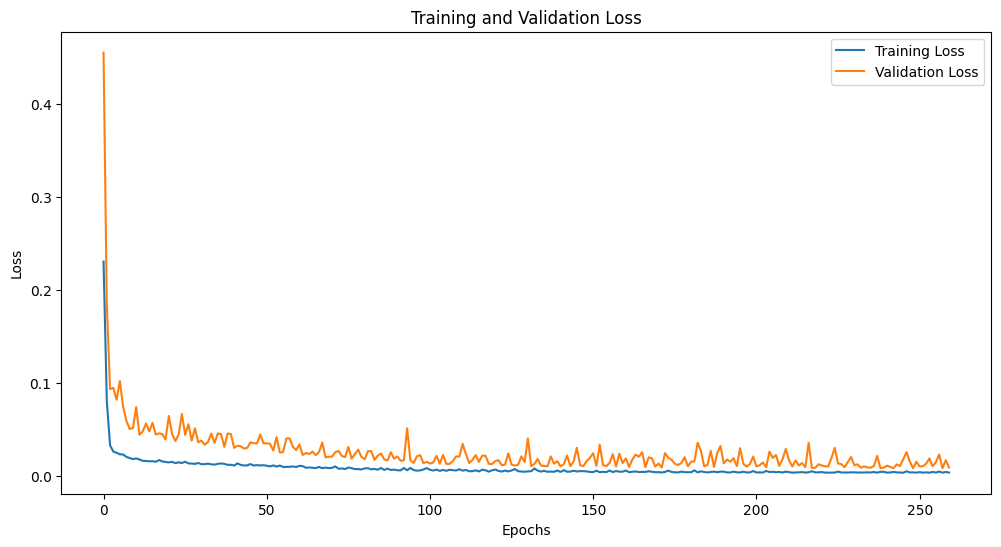

Entrenando modelo LSTM
Epoch 1/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 0.1627 - val_loss: 0.3542 - learning_rate: 1.0000e-04
Epoch 2/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0847 - val_loss: 0.1342 - learning_rate: 9.9900e-05
Epoch 3/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0288 - val_loss: 0.0317 - learning_rate: 9.9800e-05
Epoch 4/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0147 - val_loss: 0.0627 - learning_rate: 9.9701e-05
Epoch 5/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0234 - val_loss: 0.0403 - learning_rate: 9.9602e-05
Epoch 6/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0158 - val_loss: 0.0401 - learning_rate: 9.9502e-05
Epoch 7/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0130 - val_loss: 0.0574 - learning_rate: 9.9404e-05
Epoch 8/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0178 - val_loss: 0.0566 - learning_rate: 9.9305e-05
Epoch 9/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0144 - val_loss: 0.0

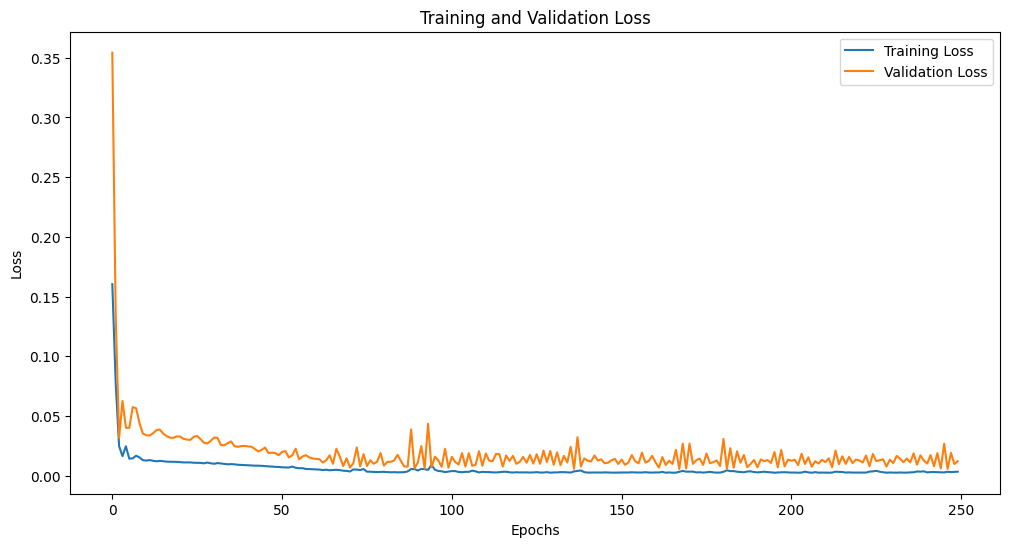

Entrenando modelo MLP
Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1006 - val_loss: 0.0981
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0379 - val_loss: 0.0401
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0131 - val_loss: 0.0549
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0162 - val_loss: 0.0422
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0093 - val_loss: 0.0150
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0080 - val_loss: 0.0135
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0054 - val_loss: 0.0150
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0052 - val_loss: 0.0162
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044 - val_loss: 0.0063
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0046 - val_loss: 0.0053
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0024 - val_loss: 0.0089
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.

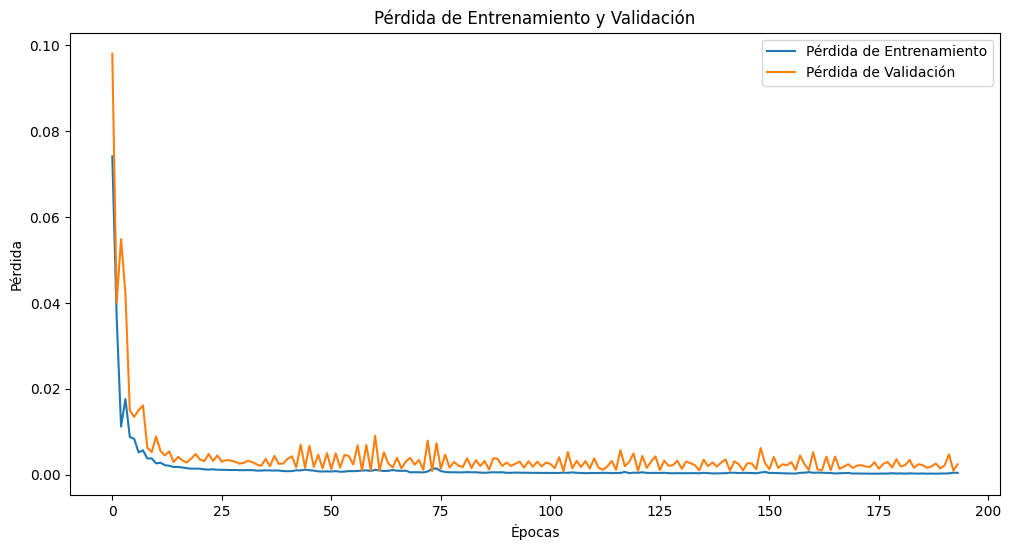

Entrenando modelo ESN


In [ ]:
from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class EnsembleModel:
    def __init__(self, models):
        self.models = models

    def train(self, X_train, y_train, X_valid, y_valid):
        """
        Entrena todos los modelos del ensamble.

        Args:
            X_train (np.ndarray): Conjunto de entrenamiento de características.
            y_train (np.ndarray): Conjunto de entrenamiento de etiquetas.
            X_valid (np.ndarray): Conjunto de validación de características.
            y_valid (np.ndarray): Conjunto de validación de etiquetas.
        """
        for name, model in self.models.items():
            print(f"Entrenando modelo {name}")
            if name != 'ESN':
                model.train(X_train, y_train, X_valid, y_valid, plot_loss=True)
            else:
                model.fit(X_train[:, :, 0], y_train)

    def ensemble_forecast(self, predictions, actuals, method='mean', weights=None):
        """
        Realiza el ensamble de pronósticos usando los métodos de media, mediana o moda.

        Args:
            predictions (np.ndarray): Array de pronósticos de forma (n_samples, n_models).
            actuals (np.ndarray): Array de valores reales.
            method (str): Método de ensamble ('mean', 'median', 'mode'). Por defecto es 'mean'.
            weights (list or str): Pesos para cada modelo en el ensamble. Puede ser una lista de pesos, 'uni' para pesos uniformes, o 'mape' para pesos basados en MAPE. Por defecto es None.

        Returns:
            np.ndarray: Pronósticos ensamblados.
        """
        if method not in ['mean', 'median', 'mode']:
            raise ValueError("El método debe ser 'mean', 'median' o 'mode'.")

        if method == 'mean':
            if weights is None or weights == 'uni':
                weights = np.ones(predictions.shape[1]) / predictions.shape[1]
            elif weights == 'mape':
                weights = self._calculate_weights(predictions, actuals)
            else:
                weights = np.array(weights)
                if weights.sum() != 1:
                    weights = weights / weights.sum()
            ensemble = np.dot(predictions, weights)

        elif method == 'median':
            ensemble = np.median(predictions, axis=1)

        elif method == 'mode':
            def find_mode(data):
                kde = gaussian_kde(data, bw_method='silverman')
                x_grid = np.linspace(data.min(), data.max(), 1000)
                kde_estimate = kde.evaluate(x_grid)
                mode_index = np.argmax(kde_estimate)
                return x_grid[mode_index]

            ensemble = np.apply_along_axis(find_mode, axis=1, arr=predictions)

        return ensemble

    def _calculate_weights(self, predictions, actuals):
        """
        Calcula los pesos basados en la puntuación MAPE de cada modelo.

        Args:
            predictions (np.ndarray): Array de pronósticos de forma (n_samples, n_models).
            actuals (np.ndarray): Array de valores reales.

        Returns:
            np.ndarray: Pesos calculados basados en MAPE.
        """
        errors = []
        for i in range(predictions.shape[1]):
            error = mape(predictions[:, i], actuals)
            errors.append(error)
        errors = np.array(errors)
        inverse_errors = 1 / errors
        weights = inverse_errors / inverse_errors.sum()
        return weights

    def predict(self, X, y_test, method='mean', weights=None):
        """
        Realiza predicciones con cada modelo y aplica el ensamble.

        Args:
            X (np.ndarray): Conjunto de características.
            y_test (np.ndarray): Valores reales de prueba.
            method (str): Método de ensamble ('mean', 'median', 'mode'). Por defecto es 'mean'.
            weights (list or str): Pesos para cada modelo en el ensamble. Puede ser una lista de pesos, 'uni' para pesos uniformes, o 'mape' para pesos basados en MAPE. Por defecto es None.

        Returns:
            np.ndarray: Predicciones ensambladas.
        """
        predictions = []
        for name, model in self.models.items():
            if name == 'ESN':
                preds = model.predict(X[:, :, 0])  # Ajuste para ESN
                preds = preds.reshape(-1, 1)
            else:
                preds = model.predict(X)
            predictions.append(preds)
        predictions = np.column_stack(predictions)
        return self.ensemble_forecast(predictions, y_test, method, weights)

    def evaluate_ensemble(self, ensemble_predictions, y_test, test_shifted, scaler, var_date):
        """
        Evalúa el rendimiento del ensamble de modelos.

        Args:
            ensemble_predictions (np.ndarray): Predicciones ensambladas.
            y_test (np.ndarray): Valores reales de prueba.
            test_shifted (pd.DataFrame): Conjunto de prueba desplazado.
            scaler (object): Objeto escalador utilizado para escalar los datos.
            var_date (str): Nombre de la columna de fecha.
        """
        ev_ts_data = pd.DataFrame(ensemble_predictions, columns=['prediction'])
        ev_ts_data[var_date] = test_shifted.index
        ev_ts_data['actual'] = np.transpose(y_test).ravel()
        ev_ts_data[['prediction', 'actual']] = scaler.inverse_transform(ev_ts_data[['prediction', 'actual']])
        print("MAPE:", mape(ev_ts_data['prediction'], ev_ts_data['actual']))
        ev_ts_data.plot(x=var_date, y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8))
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Value', fontsize=12)
        plt.show()

models = {
    'GRU': GRUModel(latent_dim=60, batch_size=32, epochs=260, horizon=1, T=T, lr=0.001, decay=0.01),
    'LSTM': LSTMModel(latent_dim=1000, batch_size=32, epochs=250, horizon=1, T=T, lr=0.0001, decay=0.001),
    'MLP': MLPModel(input_shape=(T, 1), layers=2, neurons=240, batch_size=32, epochs=200, horizon=1, lr=0.001, decay=0.01),
    'ESN': ESN(n_inputs=T, n_outputs=1, n_reservoir=750, spectral_radius=0.1, sparsity=0.1, noise=0.00001)
}

ensemble_model = EnsembleModel(models=models)

ensemble_model.train(X_train, y_train, X_valid, y_valid)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Evaluación del Ensamble
MAPE: 0.04913954032177969


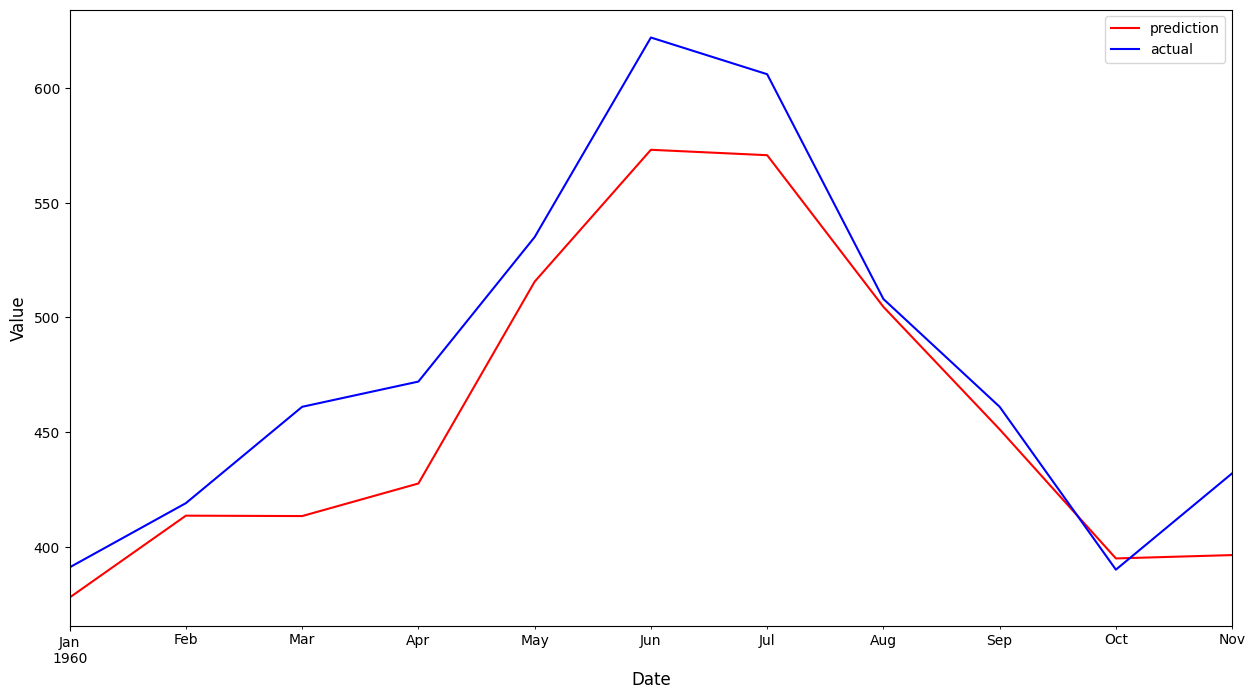

In [ ]:
ensemble_predictions = ensemble_model.predict(X_test, y_test, method='mean', weights='mape')

print("Evaluación del Ensamble")
ensemble_model.evaluate_ensemble(ensemble_predictions, y_test, test_shifted, scaler, var_date)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Evaluación del Ensamble
MAPE: 0.058044891218209015


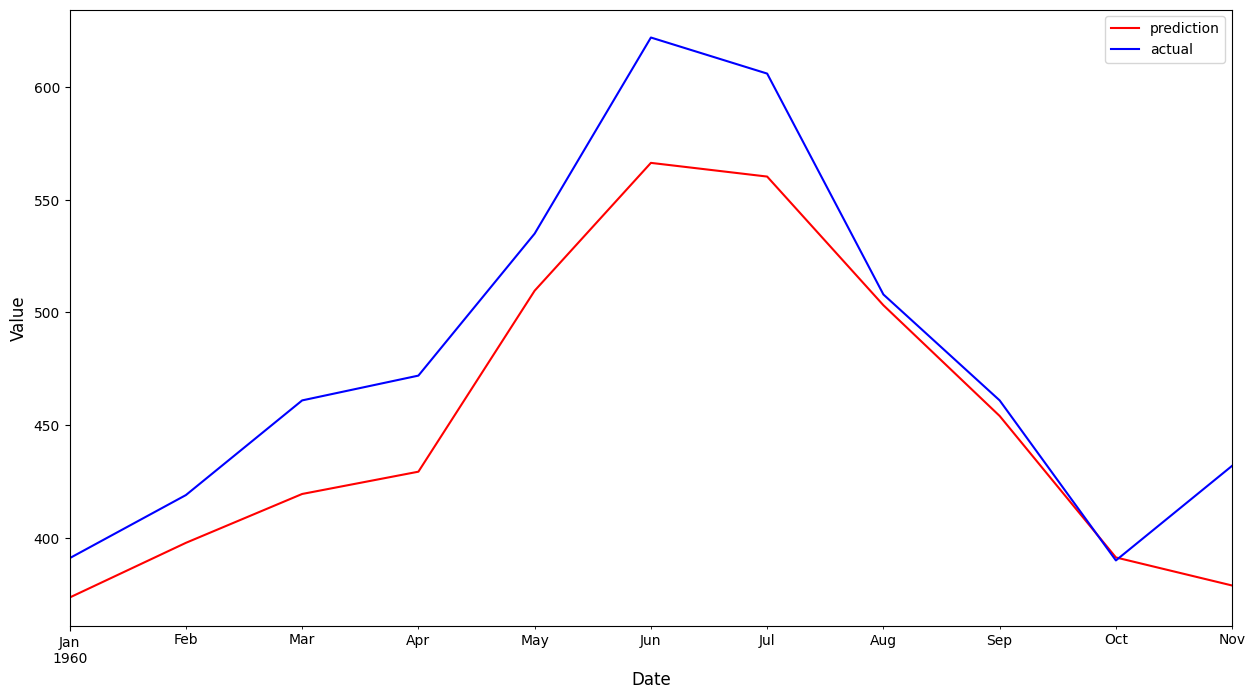

In [ ]:
ensemble_predictions = ensemble_model.predict(X_test, y_test, method='median', weights='mape')

print("Evaluación del Ensamble")
ensemble_model.evaluate_ensemble(ensemble_predictions, y_test, test_shifted, scaler, var_date)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Evaluación del Ensamble
MAPE: 0.0628303032543094


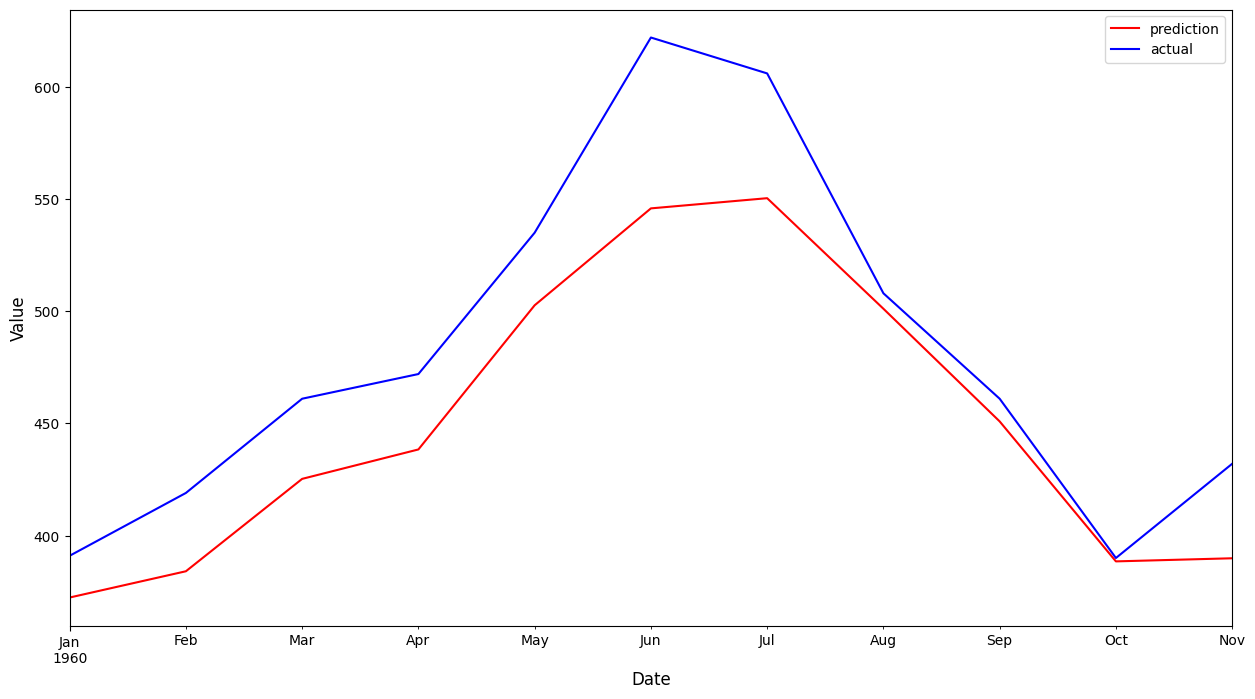

In [ ]:
ensemble_predictions = ensemble_model.predict(X_test, y_test, method='mode', weights='mape')

print("Evaluación del Ensamble")
ensemble_model.evaluate_ensemble(ensemble_predictions, y_test, test_shifted, scaler, var_date)

## SVR

0.4129109031296139


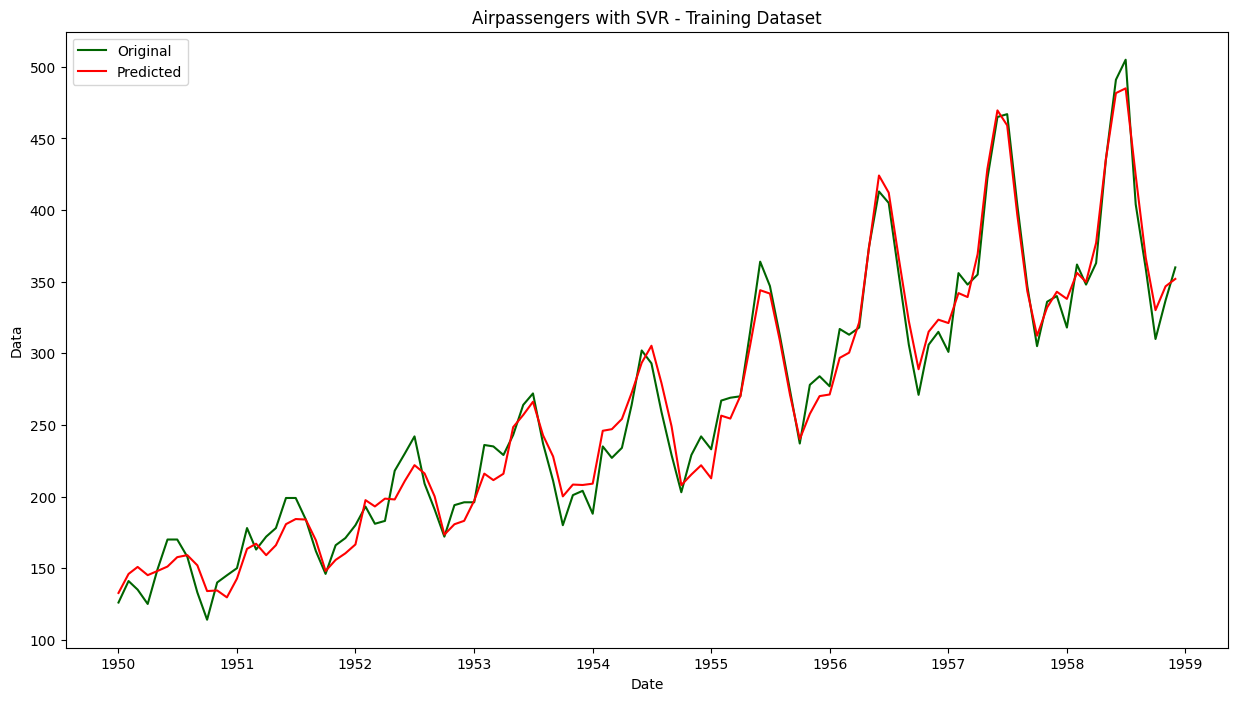

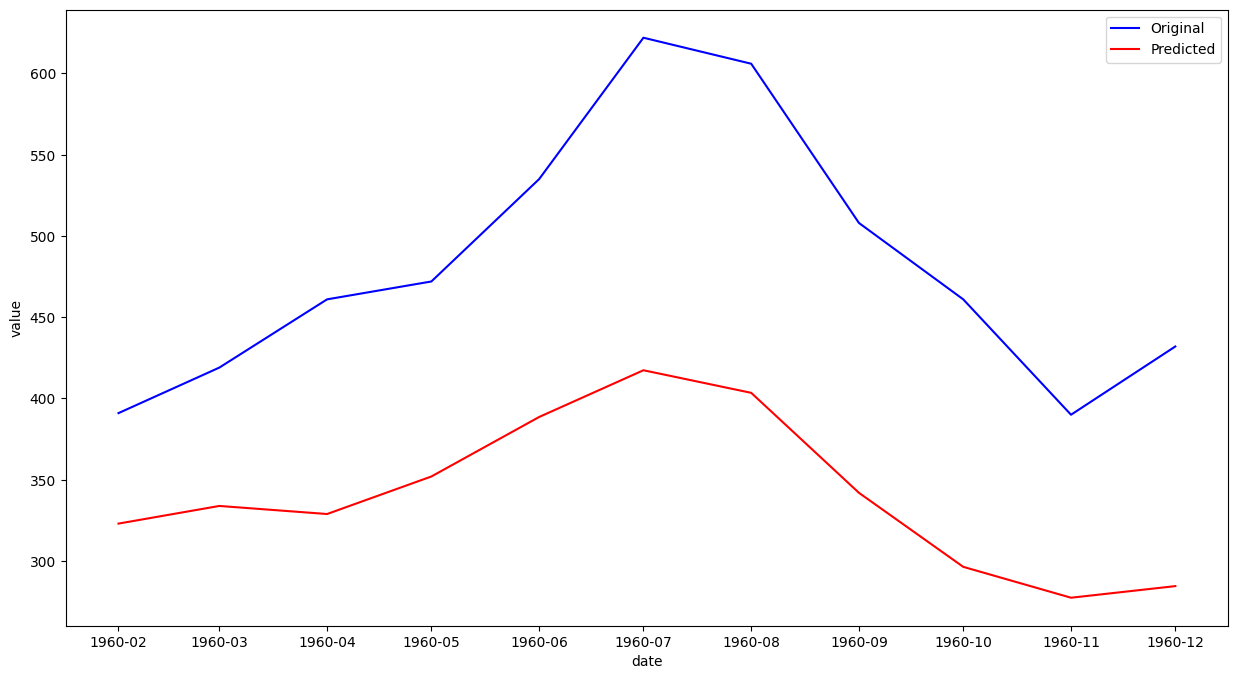

In [ ]:
############################
# Series de tiempo con SVR #
############################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# SVR model
model = SVR(kernel='rbf', gamma=0.5, C=10, epsilon=0.05)

# Fit the model
model.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Make predictions
train_pred = model.predict(X_train.reshape(X_train.shape[0], -1))
test_pred = model.predict(X_test.reshape(X_test.shape[0], -1))

# Inverse scaling
train_pred_inv = scaler.inverse_transform(train_pred.reshape(-1, 1))
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
test_pred_inv = scaler.inverse_transform(test_pred.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# MAPE
def mape(ts_predictions, actuals):
    """Mean absolute percentage error"""
    return ((np.abs(ts_predictions - actuals) / actuals).mean())

print(mape(pd.Series(y_test_inv.reshape(len(y_test_inv),)), pd.Series(test_pred_inv.reshape(len(test_pred_inv),)) ))

plt.figure(figsize=(15, 8))
plt.plot(datos.index[T:T+len(train_pred_inv)], y_train_inv, label='Original', color='darkgreen')
plt.plot(datos.index[T:T+len(train_pred_inv)], train_pred_inv, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Data')
plt.title('Airpassengers with SVR - Training Dataset')
plt.legend()
plt.show()

plt.figure(figsize=(15, 8))
plt.plot(test_data.index[1:], test_data[1:], label='Original', color='blue')
plt.plot(test_data.index[1:], test_pred_inv, label='Predicted', color='red')
plt.xlabel(var_date)
plt.ylabel(var_tar)
plt.legend()
plt.show()


## ARIMA

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
#!pip install pmdarima
from pmdarima import auto_arima
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

class ARIMA:
    def __init__(self, datos, var_date, var_tar):
        self.datos = datos.set_index(var_date)[var_tar]
        self.datos.index = pd.to_datetime(self.datos.index)
        self.datos = self.datos.asfreq('MS')

    def descomp_ets(self):
        res = seasonal_decompose(self.datos, model='multiplicative')
        res.plot()
        plt.show()

    # Ajuste automático ARIMA
    def ajuste_auto(self):
        warnings.filterwarnings("ignore")
        ajuste = auto_arima(self.datos, start_p=1, start_q=1,
                            max_p=3, max_q=3, m=12,
                            start_P=0, seasonal=True,
                            d=None, D=1, trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)
        print(ajuste.summary())

    def dividir_datos(self, test_size=12):
        self.entreno = self.datos.iloc[:len(self.datos) - test_size]
        self.prueba = self.datos.iloc[len(self.datos) - test_size:]

    def ajustar_sarimax(self):
        modelo = SARIMAX(self.entreno,
                         order=(0, 1, 1),
                         seasonal_order=(2, 1, 1, 12))
        res = modelo.fit()
        print(res.summary())

        inicio = len(self.entreno)
        fin = len(self.entreno) + len(self.prueba) - 1
        self.pred = res.predict(inicio, fin, typ='levels').rename("Predicciones")
        self.pred.plot(legend=True)
        self.prueba.plot(legend=True)
        plt.show()

    def eval_errores(self):
        print("Raíz Error Cuadrático Medio:", rmse(self.prueba, self.pred))
        print("Error Cuadrático Medio:", mean_squared_error(self.prueba, self.pred))
        print("Error Absoluto Porcentual Medio (MAPE):", mean_absolute_percentage_error(self.prueba, self.pred))

    def pronostico(self, periodos_futuros=None, start_year=None, end_year=None):
        modelo = SARIMAX(self.datos,
                         order=(0, 1, 1),
                         seasonal_order=(2, 1, 1, 12))
        res = modelo.fit()
        if start_year is not None and end_year is not None:
            start_date = f"{start_year}-12"
            end_date = f"{end_year}-11"
            self.pron = res.predict(start=start_date, end=end_date, typ='levels').rename('Pronóstico')
        elif periodos_futuros is not None:
            self.pron = res.predict(start=len(self.datos), end=len(self.datos) + periodos_futuros - 1, typ='levels').rename('Pronóstico')
        else:
            raise ValueError("Debe especificar 'periodos_futuros' o tanto 'start_year' como 'end_year'")

        self.datos.plot(figsize=(12, 5), legend=True)
        self.pron.plot(legend=True)
        plt.show()

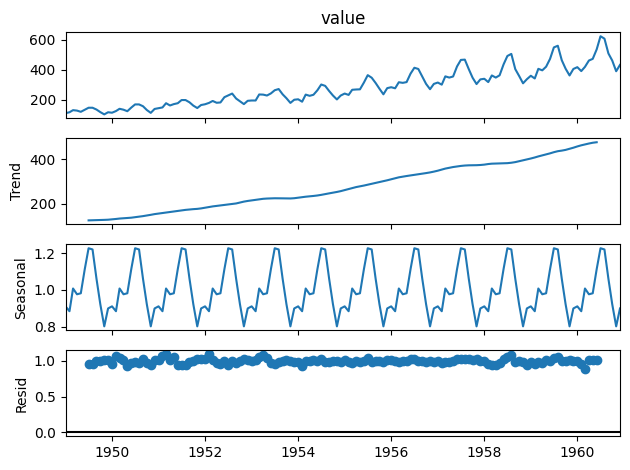

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1022.896, Time=0.76 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.37 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.82 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1020.393, Time=0.18 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1019.239, Time=1.31 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=7.38 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1020.493, Time=0.99 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1032.120, Time=0.61 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1021.120, Time=1.09 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1021.032, Time=1.49 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1019.178, Time=1.35 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1020.425, Time=0.50 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=6.11 sec
 ARIMA(0,1,1)(1,1,1)[12]     

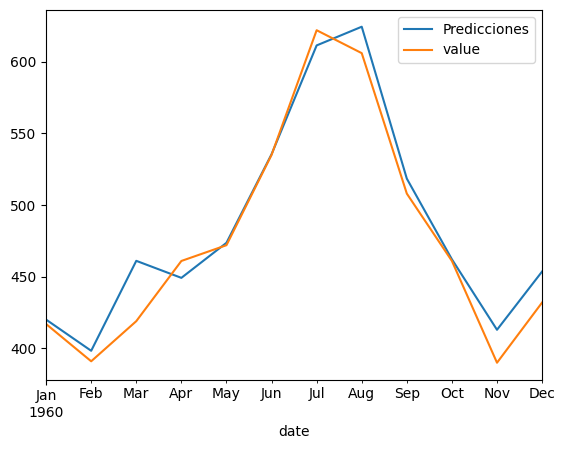

Raíz Error Cuadrático Medio: 17.167115199421534
Error Cuadrático Medio: 294.7098442702099
Error Absoluto Porcentual Medio (MAPE): 2.8010698746711147


In [8]:
# Ajuste del modelo ARIMA y pronostico
arima = ARIMA(datos, datos.index, var_tar)
arima.descomp_ets()
arima.ajuste_auto()
arima.dividir_datos()
arima.ajustar_sarimax()
arima.eval_errores()